# Lloyd's Register Foundation - A Text Analysis

Edafe Onerhime  
[ekoner.com](https://ekoner.com)  
[@ekoner](https://twitter.com/ekoner)  

In [83]:
import nltk
import string
import os.path
import itertools
import matplotlib
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from urllib.request import urlretrieve
from IPython.core.display import display, HTML

In [84]:
%matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

Using matplotlib backend: Qt5Agg


In [85]:
URL = 'http://info.lr.org/360giving-data'
fname = 'lloyds_register.xlsx'
stop = stopwords.words('english')
addStop = [] # Add more stop words where needed
punctuationExtra = string.punctuation+'’'+'“'+'”'+'…'
translator = str.maketrans('', '', punctuationExtra)
lemma = nltk.wordnet.WordNetLemmatizer()
dfAgg = pd.DataFrame()
topX = 5

In [86]:
def cleanText(col):
    # Make lower case, remove punctuation, remove numbers, lemmatize to remove plurals    
    nested = []
    for i in col.str.lower().tolist():
        nested.append([lemma.lemmatize(word.strip(punctuationExtra)) for word in i.replace('/',' ').replace('\n','').replace('\t','').replace('.',' ').replace('’',"'").replace("'s", '').split(" ") if not (word == '' or word in punctuationExtra+'–' or word in stop or word in addStop or word.translate(translator).isdigit())]    )
    return nested

def processText(col):
    # Analyse the series
    clean = Counter([item for sublist in cleanText(col) for item in sublist])
    df = pd.DataFrame.from_dict(clean, orient='index').reset_index()
    df['source'] = col.name
    df.columns = ['word','count','source']
    return df

In [87]:
def generateWordCloud(words,fname):
    # Generate a word cloud image
    wordcloud = WordCloud(background_color='white', width=2200, height=1000, margin=0,
                     ranks_only=None, prefer_horizontal=.7, mask=None, scale=2,
                     color_func=None, max_words=None, min_font_size=4,
                     stopwords=None, random_state=None,
                     max_font_size=None, font_step=1, mode='RGB',
                     relative_scaling=.5, regexp=None, collocations=True,
                     colormap=None, normalize_plurals=False)\
        .generate(words)

    # Display the generated image:
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(fname, dpi=300)

In [88]:
# Get file
if not os.path.isfile(fname):
    urlretrieve(URL, fname)

In [89]:
# Load file
df = pd.read_excel(fname)

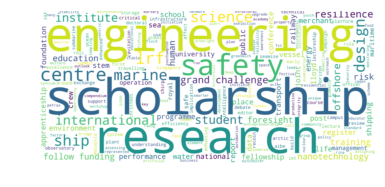

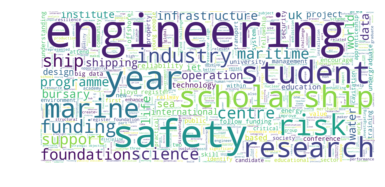

In [90]:
# Create word clouds
titleStr = ' '.join([item for sublist in cleanText(df['Title']) for item in sublist])
descStr = ' '.join([item for sublist in cleanText(df['Description']) for item in sublist])
generateWordCloud(titleStr,'title_wordcloud.png')
generateWordCloud(descStr,'desc_wordcloud.png')

In [91]:
# Top X terms
dfAgg = processText(df['Title'])
dfAgg = dfAgg.append(processText(df['Description']), ignore_index=True)
dfResult = dfAgg.groupby(by=['word'])['count'].sum().reset_index().sort_values('count', ascending=False).head(topX)
dfResult.columns = ['word','Total']
dfResult.set_index(['word'],inplace=True)
dfResult['%'] = (dfResult['Total']/dfAgg['count'].sum())*100

# Top X terms per column
dfTitleTopX = dfAgg[dfAgg['source']=='Title'][['word','count']].sort_values('count',ascending=False).head(topX).rename(columns={"word": "Title", "count": "Count"}).reset_index()
dfTitleTopX = dfTitleTopX[['Title','Count']]
dfTitleTopX['%'] = (dfTitleTopX['Count']/dfAgg[dfAgg['source']=='Title']['count'].sum())*100
dfDescTopX = dfAgg[dfAgg['source']=='Description'].sort_values('count',ascending=False).head(topX).rename(columns={"word": "Description", "count": "Count"}).reset_index()
dfDescTopX = dfDescTopX[['Description','Count']]
dfDescTopX['%'] = (dfDescTopX['Count']/dfAgg[dfAgg['source']=='Description']['count'].sum())*100

In [92]:
df['TitleTerms'] = pd.Series(cleanText(df['Title']))
df['DescriptionTerms'] = pd.Series(cleanText(df['Description']))
df['TitleDescription'] = df['Title']+' '+df['Description']
df['UniqueTerms'] = pd.Series(cleanText(df['Description'])).apply(lambda x: list(set(x)))
df['TitleCount'] = df['Title'].apply(lambda x: len(x.split()))
df['DescriptionCount'] = df['Description'].apply(lambda x: len(x.split()))
df['TitleTermsCount'] = df['TitleTerms'].apply(lambda x: len(x))
df['DescriptiionTermsCount'] = df['DescriptionTerms'].apply(lambda x: len(x))
df['UniqueTermsCount'] = df['UniqueTerms'].apply(lambda x: len(x))
df.to_csv('lloyds_register_with_terms.csv',index=False)

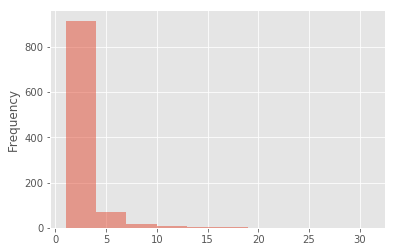

In [93]:
plt.figure();
dfAgg['count'].plot.hist(alpha=0.5)

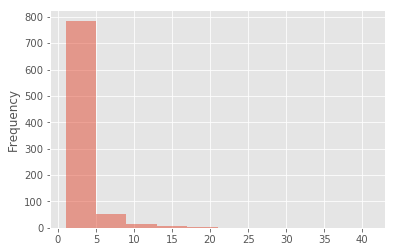

In [94]:
 dfAgg.groupby(by=['word'])['count'].sum().plot.hist(alpha=0.5)

In [95]:
print(df.shape[0],'grants to',len(df['Recipient Org:Identifier'].unique()),'recipients between', df['Award Date'].min().date().strftime("%Y"),'and',df['Award Date'].max().date().strftime("%Y"))
print('Amounts Awarded between',df['Currency'].min(),df['Amount Awarded'].min(),'and',df['Amount Awarded'].max(),'\n')
print('Top',topX,'terms')
print(dfResult[['Total','%']].to_string(),'\n')
print('Top',topX,'terms: Title & Description')
print(pd.concat([dfTitleTopX,dfDescTopX], axis=1).to_string(index=False),'\n')

77 grants to 65 recipients between 2010 and 2017
Amounts Awarded between GBP 40787 and 42979 

Top 5 terms
             Total         %
word                        
engineering     41  2.204301
safety          29  1.559140
scholarship     25  1.344086
research        23  1.236559
funding         19  1.021505 

Top 5 terms: Title & Description
Title  Count         %  Description  Count         %
scholarship     11  3.333333  engineering     31  2.026144
   research     10  3.030303       safety     21  1.372549
engineering     10  3.030303         year     16  1.045752
     safety      8  2.424242      funding     16  1.045752
     centre      8  2.424242  scholarship     14  0.915033 

